## Groupby

This notebook gives an introduction to the groupby function in Pandas. You can look at the corresponding power point slides first.

In [1]:
import pandas as pd
import numpy as np

Back to the notebook, let's make a toy DF (example taken from Wes McKinney's [Python for Data Analysis](http://proquest.safaribooksonline.com.libproxy.berkeley.edu/book/programming/python/9781491957653):

In [2]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,-0.432780,1.185643
1,a,two,0.377115,-0.024559
2,b,one,0.228950,-0.433306
3,b,two,-0.578740,-0.676225
4,a,one,0.664125,0.913051


Let's group just the `data1` column by the `key1` column. A call to [`groupby`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) does that.  

Note, the syntax is to begin by invoking the portion of the dataframe we want to group (here, `df['data1']`), then we apply the groupby method with the portion of hte dataframe we want to group on (here `df['key1']`)

What is the object that results?

In [3]:
grouped = df['data1'].groupby(df['key1'])
grouped

As we see, it's not simply a new DataFrame. Instead, it's an object, in this case `SeriesGroupBy`.  We'll see in a moment that if we group many columns of data we get a `DataFrameGroupBy` object.

To look inside we need to use different syntax.  The specific thing we're looking for are the groups of the object...but let's tab in to the grouped object to see what's there.

In [4]:
grouped.groups

{'a': [0, 1, 4], 'b': [2, 3]}

That gave us the groups (a and b) and the indices of elements in the groups, but nothing else. 

You can see this structure looks like a dict.  a and b are the keys, and the data are lists associated with each key -- the values.  

But the `grouped` object is capable of making computations across all groups -- this is where it gets powerful.   

We can try things like `sum`, `min` and `max`.

Notice if you don't put the parens after the method, pandas returns information about what the method does, but not it's actual output.  

In [5]:
grouped.sum()

key1
a    0.60846
b   -0.34979
Name: data1, dtype: float64

You can also pass `numpy` functions into the aggregate command.

But it can be informative to look at what's inside. We can iterate over a `groupby` object, as we iterate we get pairs of `(name, group)`, where the `group` is either a `Series` or a `DataFrame`, depending on whether the `groupby` object is a `SeriesGroupBy` (as above) or a `DataFrameGroupBy` (see below).

Something quirky to note about the interaction between the grouped object and the for loop structure below: we're going to define variables `name` and `group` as being things in `grouped`.  But there are no `name` or `group` attributes associated with the `grouped` object.  

In [6]:
for name, group in grouped:
    print('Name:', name)
    display(group)

Name: a


0   -0.432780
1    0.377115
4    0.664125
Name: data1, dtype: float64

Name: b


2    0.22895
3   -0.57874
Name: data1, dtype: float64

We can group on multiple keys, and the result is grouping by tuples:

In [7]:
g2 = df['data1'].groupby([df['key1'], df['key2']])
g2

In [8]:
g2.groups

{('a', 'one'): [0, 4], ('a', 'two'): [1], ('b', 'one'): [2], ('b', 'two'): [3]}

Now we have a groupby object that has tuples as the keys.  

In [9]:
g2.mean()

key1  key2
a     one     0.115673
      two     0.377115
b     one     0.228950
      two    -0.578740
Name: data1, dtype: float64

### Aside (did not do in lecture)
We can also group the entire dataframe -- not just one column of it -- on a single key. This results in a `DataFrameGroupBy` object as the result:

In [10]:
k1g = df.groupby('key1')
k1g

In [11]:
k1g.groups

{'a': [0, 1, 4], 'b': [2, 3]}

That output actually looks a lot like the output when we were only grouping one of the columns of the dataframe.  But there is actually more information in the group itself.  

In [12]:
for name, group in k1g:
    print('Name:', name)
    display(group)

Name: a


,key1,key2,data1,data2
0,a,one,-0.432780,1.185643
1,a,two,0.377115,-0.024559
4,a,one,0.664125,0.913051


Name: b


,key1,key2,data1,data2
2,b,one,0.22895,-0.433306
3,b,two,-0.57874,-0.676225


The contents of each group is another dataframe.

### Aside (did not do in lecture): Grouping over a different dimension

Above, we've been grouping data along the rows, using column keys as our selectors.  

But we can also group along the *columns*, 

What's even more cool?  We can group by *data type*.

Here we'll group along columns, by data type:

In [20]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [21]:
grouped = df.groupby(df.dtypes, axis=1)
for dtype, group in grouped:
    print(dtype)
    display(group)

float64


,data1,data2
0,-0.432780,1.185643
1,0.377115,-0.024559
2,0.228950,-0.433306
3,-0.578740,-0.676225
4,0.664125,0.913051


object


,key1,key2
0,a,one
1,a,two
2,b,one
3,b,two
4,a,one


## Using groupby to re-ask our question 
*(did not do this in lecture, instead did CAISO forecasting error example)*
Which hour had the lowest average wind production?

In [22]:
cds = pd.read_csv('CAISO_2017to2018_stack.csv', index_col= 0)

In [23]:
cds.head()

,Source,MWh
2017-08-29 00:00:00,GEOTHERMAL,1181
2017-08-29 00:00:00,BIOMASS,340
2017-08-29 00:00:00,BIOGAS,156
2017-08-29 00:00:00,SMALL HYDRO,324
2017-08-29 00:00:00,WIND TOTAL,1551


It will help to have a column of hour of day values:

In [24]:
cds_time = pd.to_datetime(cds.index)
type(cds_time)

pandas.core.indexes.datetimes.DatetimeIndex

Let's add that list of values into the data frame.

In [25]:
cds['hour'] = cds_time.hour

In [26]:
cds.head(10)

,Source,MWh,hour
2017-08-29 00:00:00,GEOTHERMAL,1181,0
2017-08-29 00:00:00,BIOMASS,340,0
2017-08-29 00:00:00,BIOGAS,156,0
2017-08-29 00:00:00,SMALL HYDRO,324,0
2017-08-29 00:00:00,WIND TOTAL,1551,0
2017-08-29 00:00:00,SOLAR PV,0,0
2017-08-29 00:00:00,SOLAR THERMAL,0,0
2017-08-29 01:00:00,GEOTHERMAL,1182,1
2017-08-29 01:00:00,BIOMASS,338,1
2017-08-29 01:00:00,BIOGAS,156,1


### Q: What groupby syntax would you use to arrange the data...
...so that you can examine production by hour and source?

See if you can do it yourself: we want to group MWh values by source AND hour.

In [27]:
cds_grouped = cds['MWh'].groupby([cds['Source'],cds['hour']])

### Q: How to get *all* the means for all sources and hours?

Didn't need to do any fancy logical indexing or looping!

In [28]:
cds_grouped.mean()

Source      hour
BIOGAS      0        225.591781
            1        225.964384
            2        225.953425
            3        225.887671
            4        225.753425
                       ...     
WIND TOTAL  19      2181.361644
            20      2229.408219
            21      2231.687671
            22      2220.109589
            23      2216.526027
Name: MWh, Length: 168, dtype: float64

Now it would be nice to see that information in a dataframe, wouldn't it?

In [29]:
averages = pd.DataFrame(cds_grouped.mean())

In [30]:
averages

MWh
Source     hour             
BIOGAS     0      225.591781
           1      225.964384
           2      225.953425
           3      225.887671
           4      225.753425
...                      ...
WIND TOTAL 19    2181.361644
           20    2229.408219
           21    2231.687671
           22    2220.109589
           23    2216.526027

[168 rows x 1 columns]

And lo and behold, we have a multilevel index for the rows!

In [31]:
averages.loc[('WIND TOTAL',),:]

,MWh
hour,
0,2173.268493
1,2120.778082
2,2051.832877
3,1973.969863
4,1881.463014
5,1772.484932
6,1646.630137
7,1490.194521
8,1363.402740


But now we can look at other sources

In [32]:
averages.loc[('SMALL HYDRO',),:]

,MWh
hour,
0,330.824658
1,322.421918
2,318.249315
3,316.909589
4,322.254795
5,375.180822
6,426.931507
7,422.564384
8,376.813699


Let's plot:

In [33]:
import matplotlib.pyplot as plt

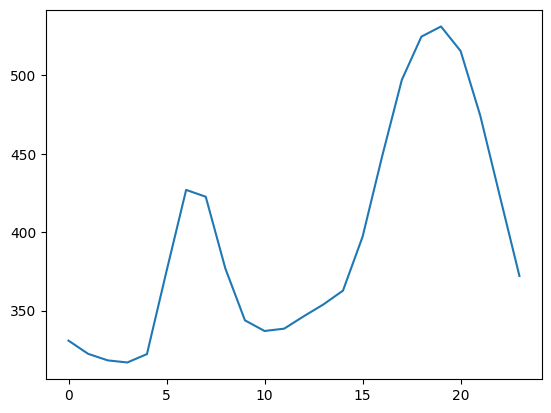

In [34]:
plt.plot(averages.loc[('SMALL HYDRO',),:]);

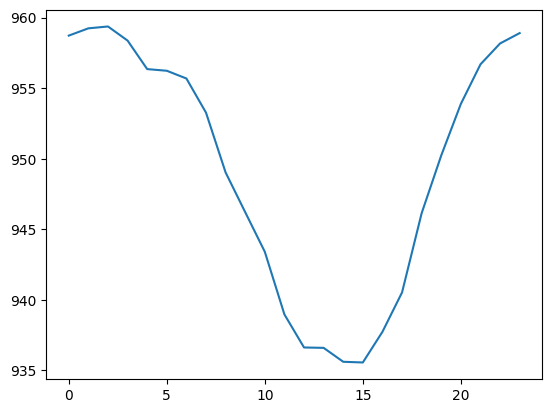

In [35]:
plt.plot(averages.loc[('GEOTHERMAL',),:]);

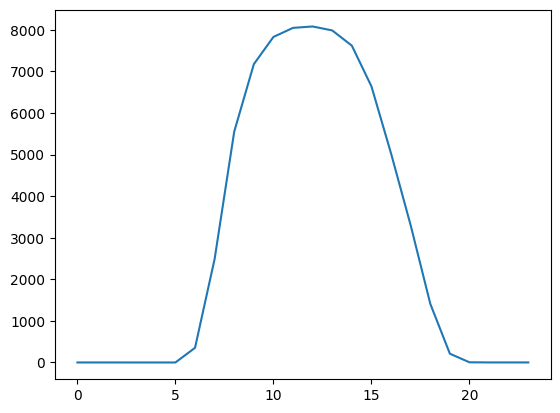

In [36]:
plt.plot(averages.loc[('SOLAR PV',),:]);